In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

In [88]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [89]:
salary_file = pd.ExcelFile('../contract_data/salaries_1985to2020_final.xlsx')
salaries = pd.read_excel(salary_file, 0)
players_info = pd.read_excel(salary_file, 1)

In [90]:
### add years of the contract
years = list(salaries.groupby('player_id').apply(lambda x: [i for i in range(1, len(x)+1)]))
flatten = lambda l: [item for sublist in l for item in sublist]
salaries['years'] = flatten(years)

In [91]:
salaries_98_20 = salaries.loc[salaries['season_end'] >= 1999]
unique_ids = list(pd.unique(salaries_98_20['player_id']))
filtered_players_info = players_info.loc[[True if pid in unique_ids else False for pid in players_info['_id']]]

In [92]:
# Deal with rookie contracts of first round picks and second round picks
# separately. 
first_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '1st round']
second_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '2nd round']

In [93]:
salaries_first_round = salaries_98_20.loc[[True if pid in list(first_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 4 or less
# Prior to 2011 CBA, first round rookie contract is a 3+1 contract with the fourth year being team option
# After 2011 CBA, first round rookie contract is a 2+2 contract with both the 3rd and 4th year being team options
# Dropping values will potentially over-dropping some datapoints
salaries_first_round = salaries_first_round.loc[salaries_first_round['years'] > 4]

salaries_second_round = salaries_98_20.loc[[True if pid in list(second_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 3 or less
salaries_second_round = salaries_second_round.loc[salaries_second_round['years'] > 3]

In [94]:
# Following part is for fixing data in all stats

In [95]:
stats = pd.read_excel('../season_data/advanced_stats/FINAL_ADVANCED_STATS/all_seasons_advanced_stats.xlsx')

In [96]:
stats['error_in_name'] = stats['Year'].apply(lambda x: x is np.nan)
stats_need_fix = stats.loc[stats['error_in_name'] == True]

In [97]:
stats_need_fix['Year'] = '2019-20'
name = stats_need_fix['name'].apply(lambda x: re.sub(r"\\.+", "", x))
slug = stats_need_fix['name'].apply(lambda x: re.sub(r".+\\", "", x))
stats_need_fix['name'], stats_need_fix['slug'] = name, slug

In [98]:
stats = stats.loc[stats['error_in_name'] == False].append(stats_need_fix).drop(columns=['error_in_name'])

In [99]:
# Create a primary key in two salaries table for joins
salaries_first_round['key'] = salaries_first_round['player_id'] + " " + salaries_first_round['season']
salaries_second_round['key'] = salaries_second_round['player_id'] + " " + salaries_second_round['season']
stats['key'] = stats['slug'] + " " + stats['Year']

In [100]:
salaries_stats_first_round = salaries_first_round.join(stats.set_index('key'), on='key', how='left')
salaries_stats_second_round = salaries_second_round.join(stats.set_index('key'), on='key', how='left')

In [101]:
first_round_counts = salaries_stats_first_round[['names', 'key']].groupby('key').count()
second_round_counts = salaries_stats_second_round[['names', 'key']].groupby('key').count()
not_traded_mid_season_first_round = list(first_round_counts.loc[first_round_counts['names'] == 1].index)
not_traded_mid_season_second_round = list(second_round_counts.loc[second_round_counts['names'] == 1].index)

In [102]:
np.unique(salaries_stats_first_round['season'])

array(['1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04',
       '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10',
       '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16',
       '2016-17', '2017-18', '2018-19', '2019-20'], dtype=object)

In [103]:
salaries_stats_first_round.set_index('key').loc[not_traded_mid_season_first_round]

,names,player_id,salary,season,season_end,season_start,years,name,positions,age,team,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_combined_totals,Year,slug
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abdulma02 2000-01,Mahmoud Abdul-Rauf,abdulma02,798500,2000-01,2001,2000,9,Mahmoud Abdul-Rauf,POINT GUARD,31.0,VANCOUVER GRIZZLIES,41.0,486.0,16.7,0.514,0.057,0.118,1.2,4.7,2.9,32.7,1.0,0.1,9.1,26.8,0.7,0.0,0.7,0.070,1.1,-2.1,-1.0,0.1,False,2000-01,abdulma02
abdulta01 2002-03,Tariq Abdul-Wahad,abdulta01,5625000,2002-03,2003,2002,6,Tariq Abdul-Wahad,SHOOTING GUARD,28.0,DALLAS MAVERICKS,14.0,204.0,12.4,0.470,0.017,0.103,7.6,14.0,10.8,15.4,1.5,1.1,10.3,15.0,0.2,0.2,0.4,0.104,-1.6,0.2,-1.4,0.0,False,2002-03,abdulta01
abdulta01 2003-04,Tariq Abdul-Wahad,abdulta01,6187500,2003-04,2004,2003,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abdulta01 2004-05,Tariq Abdul-Wahad,abdulta01,6750000,2004-05,2005,2004,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abdulta01 2005-06,Tariq Abdul-Wahad,abdulta01,3656250,2005-06,2006,2005,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zelleco01 2017-18,Cody Zeller,zelleco01,12584270,2017-18,2018,2017,5,Cody Zeller,CENTER,25.0,CHARLOTTE HORNETS,33.0,627.0,15.9,0.602,0.019,0.545,11.4,19.3,15.3,7.4,1.1,2.8,14.6,15.7,1.2,0.7,1.9,0.145,-1.2,0.0,-1.2,0.1,False,2017-18,zelleco01
zelleco01 2018-19,Cody Zeller,zelleco01,13528090,2018-19,2019,2018,6,Cody Zeller,CENTER,26.0,CHARLOTTE HORNETS,49.0,1243.0,17.2,0.611,0.064,0.409,9.4,19.7,14.5,12.1,1.5,2.9,13.2,16.3,2.6,1.2,3.9,0.150,-0.6,0.7,0.1,0.7,False,2018-19,zelleco01
zelleco01 2019-20,Cody Zeller,zelleco01,14471910,2019-20,2020,2019,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
salary_caps_file = pd.ExcelFile('salary_caps.xlsx')
salary_caps = pd.read_excel(salary_caps_file, 0)
salary_caps = salary_caps.drop(columns=salary_caps.columns[0])
salary_caps_99_20 = salary_caps.set_index('season').loc[np.unique(salaries_stats_first_round['season'])]

In [105]:
salaries_stats_first_round = salaries_stats_first_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_first_round = salaries_stats_first_round[salaries_stats_first_round['name'].notna()]
salaries_stats_second_round = salaries_stats_second_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_second_round = salaries_stats_second_round[salaries_stats_second_round['name'].notna()]

In [106]:
salaries_stats_first_round['cap_space_usage'] = salaries_stats_first_round['salary'] / salaries_stats_first_round['salary_cap']
salaries_stats_second_round['cap_space_usage'] = salaries_stats_second_round['salary'] / salaries_stats_second_round['salary_cap']
salaries_stats_first_round['minutes_per_game'] = salaries_stats_first_round['minutes_played'] / salaries_stats_first_round['games_played']
salaries_stats_second_round['minutes_per_game'] = salaries_stats_second_round['minutes_played'] / salaries_stats_second_round['games_played']

In [110]:
def standardize(df, column):
    series = []
    for i in df[column]:
        series.append((i - df[column].mean())/df[column].std())
    return series

def correlation(df, column_1, column_2):
    return np.mean(df[column_1] * df[column_2])

def scatter_and_correlation(df, column_1, column_2, ax, order):
    copy = df.copy()
    copy[column_1 + "_standard"] = standardize(df, column_1)
    copy[column_2 + "_standard"] = standardize(df, column_2)
    copy.plot.scatter(x = column_1 + "_standard", y = column_2 + '_standard', ax=ax[order])
    return correlation(copy, column_1 + '_standard', column_2 + '_standard')

In [71]:
salaries_stats_first_round.loc[salaries_stats_first_round['minutes_played'] >= 800]

,names,player_id,salary,season,season_end,season_start,key,years,name,positions,age,team,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_combined_totals,Year,slug,salary_cap,cap_space_usage,minutes_per_game
32,Shareef Abdur-Rahim,abdursh01,12375000,2002-03,2003,2002,abdursh01 2002-03,5,Shareef Abdur-Rahim,POWER FORWARD,26.0,ATLANTA HAWKS,81.0,3087.0,19.9,0.566,0.051,0.457,6.7,17.8,12.5,14.7,1.5,0.9,13.0,24.2,7.4,2.3,9.7,0.151,2.3,-0.7,1.6,2.8,False,2002-03,abdursh01,40271000,0.307293,38.111111
33,Shareef Abdur-Rahim,abdursh01,13500000,2003-04,2004,2003,abdursh01 2003-04,6,Shareef Abdur-Rahim,POWER FORWARD,27.0,ATLANTA HAWKS,53.0,1956.0,21.2,0.568,0.029,0.423,8.2,20.3,14.3,12.6,1.2,0.7,12.3,24.8,5.3,1.3,6.6,0.163,3.3,-1.0,2.3,2.1,False,2003-04,abdursh01,43840000,0.307938,36.905660
34,Shareef Abdur-Rahim,abdursh01,14625000,2004-05,2005,2004,abdursh01 2004-05,7,Shareef Abdur-Rahim,POWER FORWARD,28.0,PORTLAND TRAIL BLAZERS,54.0,1867.0,18.7,0.581,0.058,0.379,7.9,16.0,12.1,10.7,1.4,1.0,13.0,22.1,3.9,1.5,5.4,0.139,1.6,-0.6,0.9,1.4,False,2004-05,abdursh01,43870000,0.333371,34.574074
35,Shareef Abdur-Rahim,abdursh01,5000000,2005-06,2006,2005,abdursh01 2005-06,8,Shareef Abdur-Rahim,POWER FORWARD,29.0,SACRAMENTO KINGS,72.0,1961.0,17.2,0.588,0.035,0.440,6.4,14.8,10.6,13.2,1.3,1.6,12.5,20.1,4.0,2.2,6.2,0.152,0.5,0.4,0.9,1.4,False,2005-06,abdursh01,49500000,0.101010,27.236111
36,Shareef Abdur-Rahim,abdursh01,5400000,2006-07,2007,2006,abdursh01 2006-07,9,Shareef Abdur-Rahim,CENTER,30.0,SACRAMENTO KINGS,80.0,2015.0,13.1,0.524,0.031,0.358,7.0,16.4,11.6,9.2,1.3,1.5,13.3,19.5,1.1,1.7,2.8,0.067,-2.0,-0.5,-2.5,-0.2,False,2006-07,abdursh01,53135000,0.101628,25.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15147,Thaddeus Young,youngth01,11200000,2015-16,2016,2015,youngth01 2015-16,9,Thaddeus Young,POWER FORWARD,27.0,BROOKLYN NETS,73.0,2407.0,17.5,0.533,0.031,0.169,8.1,23.0,15.4,9.5,2.3,1.2,11.6,21.6,1.9,2.2,4.1,0.081,0.1,-0.1,0.0,1.2,False,2015-16,youngth01,70000000,0.160000,32.972603
15148,Thaddeus Young,youngth01,14153652,2016-17,2017,2016,youngth01 2016-17,10,Thaddeus Young,POWER FORWARD,28.0,INDIANA PACERS,74.0,2237.0,14.9,0.562,0.172,0.125,6.7,15.7,11.2,8.4,2.5,1.1,11.6,16.4,2.0,2.7,4.6,0.100,-0.3,0.8,0.5,1.4,False,2016-17,youngth01,94143000,0.150342,30.229730
15149,Thaddeus Young,youngth01,14796348,2017-18,2018,2017,youngth01 2017-18,11,Thaddeus Young,POWER FORWARD,29.0,INDIANA PACERS,81.0,2607.0,14.8,0.528,0.209,0.106,8.0,14.1,11.1,8.5,2.6,1.2,10.4,17.3,2.3,3.2,5.5,0.101,-0.2,0.4,0.2,1.4,False,2017-18,youngth01,99093000,0.149318,32.185185
15150,Thaddeus Young,youngth01,13764045,2018-19,2019,2018,youngth01 2018-19,12,Thaddeus Young,POWER FORWARD,30.0,INDIANA PACERS,81.0,2489.0,16.2,0.569,0.174,0.161,8.7,14.4,11.7,12.0,2.4,1.3,12.0,18.0,3.0,3.9,6.9,0.133,0.4,1.1,1.5,2.2,False,2018-19,youngth01,101869000,0.135115,30.728395


In [114]:
prelim_filter = salaries_stats_first_round.loc[salaries_stats_first_round['minutes_played'] >= 800]

(0.5667441270666084, 0.5046322846646705)

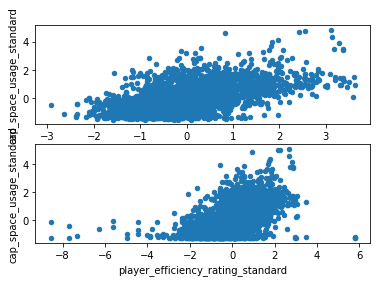

In [115]:
fig, ax = plt.subplots(2,1)
corr_filtered = scatter_and_correlation(prelim_filter, 'player_efficiency_rating', 'cap_space_usage', ax, 0)
corr_unfiltered = scatter_and_correlation(salaries_stats_first_round, 'player_efficiency_rating', 'cap_space_usage', ax, 1)
corr_filtered, corr_unfiltered

(0.48717845842310076, 0.5402105213826979)

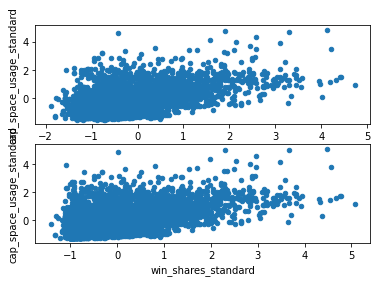

In [116]:
fig, ax = plt.subplots(2,1)
corr_filtered = scatter_and_correlation(prelim_filter, 'win_shares', 'cap_space_usage', ax, 0)
corr_unfiltered = scatter_and_correlation(salaries_stats_first_round, 'win_shares', 'cap_space_usage', ax, 1)
corr_filtered, corr_unfiltered

(0.5131964958271739, 0.5417845045187244)

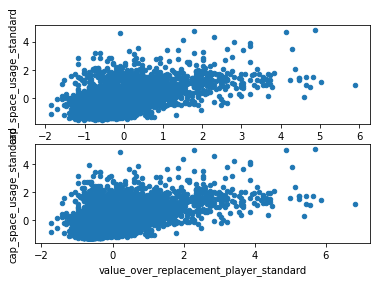

In [117]:
fig, ax = plt.subplots(2,1)
corr_filtered = scatter_and_correlation(prelim_filter, 'value_over_replacement_player', 'cap_space_usage', ax, 0)
corr_unfiltered = scatter_and_correlation(salaries_stats_first_round, 'value_over_replacement_player', 'cap_space_usage', ax, 1)
corr_filtered, corr_unfiltered

(0.47605682164256485, 0.42547837909763336)

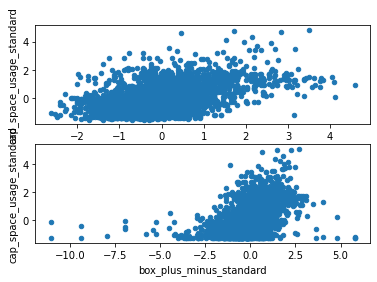

In [118]:
fig, ax = plt.subplots(2,1)
corr_filtered = scatter_and_correlation(prelim_filter, 'box_plus_minus', 'cap_space_usage', ax, 0)
corr_unfiltered = scatter_and_correlation(salaries_stats_first_round, 'box_plus_minus', 'cap_space_usage', ax, 1)
corr_filtered, corr_unfiltered

(0.20870218672152344, 0.23851381855774886)

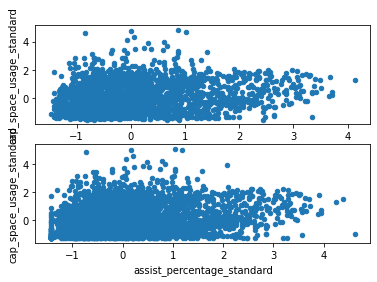

In [119]:
fig, ax = plt.subplots(2,1)
corr_filtered = scatter_and_correlation(prelim_filter, 'assist_percentage', 'cap_space_usage', ax, 0)
corr_unfiltered = scatter_and_correlation(salaries_stats_first_round, 'assist_percentage', 'cap_space_usage', ax, 1)
corr_filtered, corr_unfiltered

(0.14568655606572062, 0.20354191661496046)

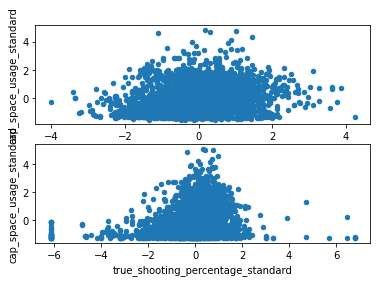

In [120]:
fig, ax = plt.subplots(2,1)
corr_filtered = scatter_and_correlation(prelim_filter, 'true_shooting_percentage', 'cap_space_usage', ax, 0)
corr_unfiltered = scatter_and_correlation(salaries_stats_first_round, 'true_shooting_percentage', 'cap_space_usage', ax, 1)
corr_filtered, corr_unfiltered

<ipython-input-26-89eeff257dcc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_1 + "_standard"] = standardize(df, column_1)
<ipython-input-26-89eeff257dcc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_2 + "_standard"] = standardize(df, column_2)


-0.08158868405398881

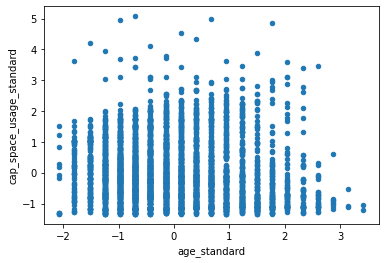

In [39]:
scatter_and_correlation(prelim_filter, 'age', 'cap_space_usage')